In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
TARGET_FEATURE_NAME = "label"
TARGET_FEATURE_LABELS = ["0", "1"]
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

# Numeric Feature
NUMERIC_FEATURE_NAMES = [
    'movieAvgRating',
    'movieRatingStddev',
    'movieRatingCount',
    'userAvgRating',
    'userRatingStddev',
    'userRatingCount',
    'releaseYear',
]

# ID Feature
ID_FEATURE_NAMES = ['movieId', 'userId']

# Categorical Feature
genre_vocab = ['Film-Noir', 'Action', 'Adventure', 
               'Horror', 'Romance', 'War', 
               'Comedy', 'Western', 'Documentary',
               'Sci-Fi', 'Drama', 'Thriller',
               'Crime', 'Fantasy', 'Animation', 
               'IMAX', 'Mystery', 'Children', 'Musical']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    'userGenre1': genre_vocab,
    'userGenre2': genre_vocab,
    'userGenre3': genre_vocab,
    'userGenre4': genre_vocab,
    'userGenre5': genre_vocab,
    'movieGenre1': genre_vocab,
    'movieGenre2': genre_vocab,
    'movieGenre3': genre_vocab
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES + ID_FEATURE_NAMES

# 读取CSV时的缺失值填充
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in FEATURE_NAMES
]

In [3]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        if feature_name in ID_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [8]:
def encode_fm_inputs(inputs, embedding_dims=10):
    encoded_cols = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            cat_col = tf.feature_column.categorical_column_with_hash_bucket(
                key=feature_name, hash_bucket_size=10)
            emb_col = tf.feature_column.embedding_column(cat_col, embedding_dims)
            
        elif feature_name in ID_FEATURE_NAMES:
            cat_col = tf.feature_column.categorical_column_with_hash_bucket(
                key=feature_name, hash_bucket_size=1000)
            emb_col = tf.feature_column.embedding_column(cat_col, embedding_dims)
            
        elif feature_name in NUMERIC_FEATURE_NAMES:
            num = tf.feature_column.numeric_column(key=feature_name)
            bucket = tf.feature_column.bucketized_column(num, boundaries = [0,5,10])
            emb_col = tf.feature_column.embedding_column(bucket, embedding_dims)
#             emb_col = tf.feature_column.numeric_column(feature_name)
            
        encoded_cols.append(emb_col)
    return encoded_cols

In [9]:
class FM_Layer(keras.layers.Layer):
    def __init__(self, feature_num, k=10, w_reg=1e-6):
        """
        Factorization Machines
        :param feature_columns: A list. sparse column feature information.
        :param k: the latent vector
        :param w_reg: the regularization coefficient of parameter w
        :param v_reg: the regularization coefficient of parameter v
        """
        super(FM_Layer, self).__init__()
        self.k = k
        self.w_reg = w_reg
        self.feature_num = feature_num
        
    def build(self, input_shape):
        print(input_shape)
        self.bias = self.add_weight(name='bias', shape=(1,),
                                  initializer=tf.zeros_initializer(),
                                  trainable=True)
        self.W = self.add_weight(name='W', shape=(input_shape[1], 1),
                                 initializer=tf.random_normal_initializer(),
                                 regularizer=keras.regularizers.l2(self.w_reg),
                                 trainable=True)

    def call(self, inputs, **kwargs):
        # linear_part
        linear_part = self.bias + tf.matmul(inputs, self.W)  # (batch_size, 1)
        print(linear_part.shape)
        
        # interaction_part
        fm_inputs = tf.reshape(inputs, (-1, self.feature_num, self.k))
        print(fm_inputs.shape)
        square_sum = tf.square(tf.reduce_sum(fm_inputs, axis=1))  # (batch_size, embed_dim)
        sum_square = tf.reduce_sum(tf.square(fm_inputs), axis=1)  # (batch_size, embed_dim)
        interaction_part = 0.5 * tf.reduce_sum(square_sum - sum_square, axis=1)  # (batch_size,)
        interaction_part = tf.expand_dims(interaction_part, 1) # (batch_size, 1)
        print(interaction_part.shape)
        
        # outputs
        outputs = linear_part + interaction_part
        return outputs

In [10]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 12
num_epochs = 3

(None, 170)
(None, 1)
(None, 17, 10)
(None, 1)


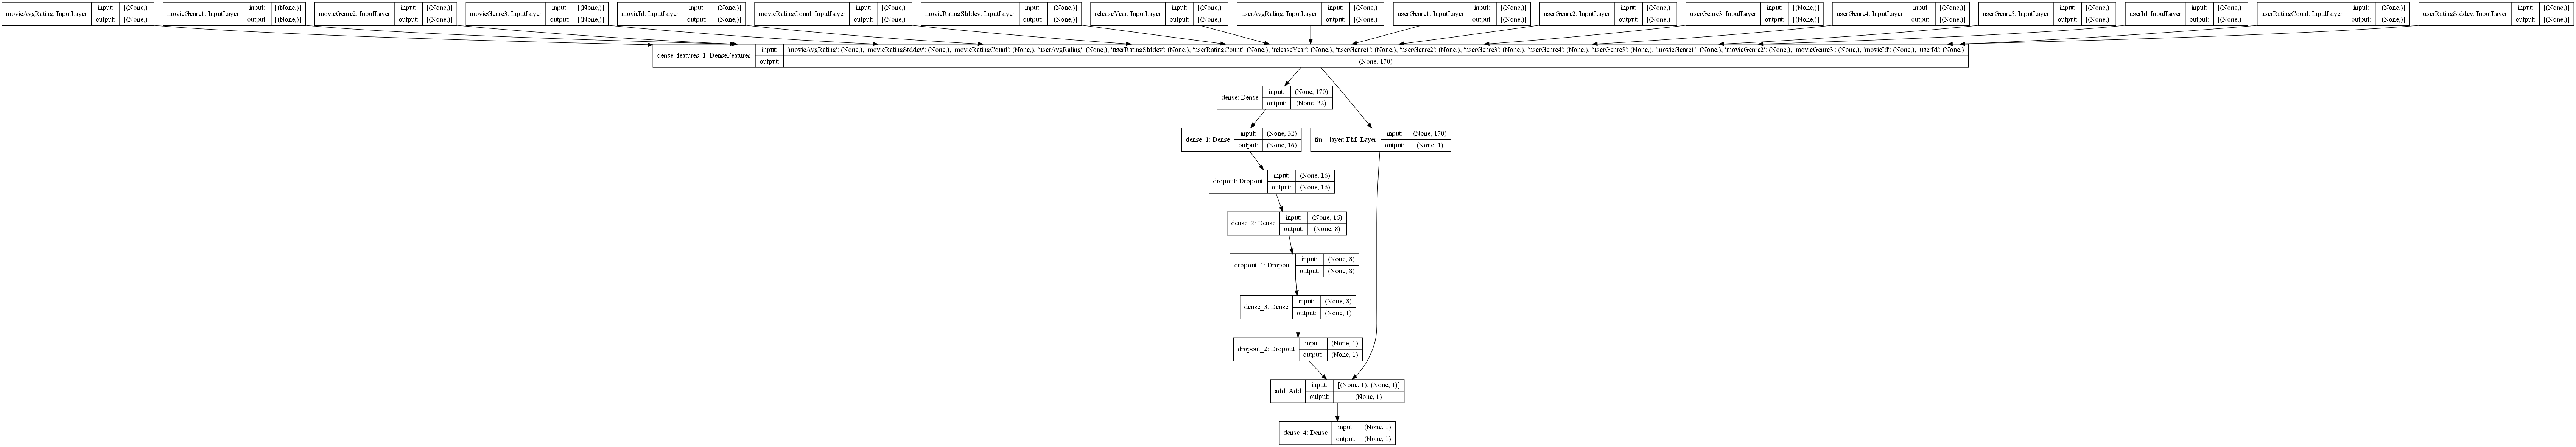

In [11]:
def create_DeepFM_model():
    embedding_dims = 10
    inputs = create_model_inputs()
    encoded_cols = encode_fm_inputs(inputs=inputs, embedding_dims=embedding_dims)
    fm_inputs = tf.keras.layers.DenseFeatures(encoded_cols)(inputs)
    fm_outputs = FM_Layer(feature_num=17, k=embedding_dims)(fm_inputs)

    deep_outputs = keras.layers.Dense(32, activation='relu')(fm_inputs)
    deep_outputs = keras.layers.Dropout(0.5)(keras.layers.Dense(16, activation='relu')(deep_outputs))
    deep_outputs = keras.layers.Dropout(0.5)(keras.layers.Dense(8, activation='relu')(deep_outputs))
    deep_outputs = keras.layers.Dropout(0.5)(keras.layers.Dense(1, activation='relu')(deep_outputs))

    add_output =  keras.layers.add([fm_outputs, deep_outputs])

    outputs = keras.layers.Dense(1, activation='sigmoid')(add_output)
    model = tf.keras.Model(inputs, outputs)
    return model
    
DeepFM_model = create_DeepFM_model()
keras.utils.plot_model(DeepFM_model, show_shapes=True, rankdir="TB")

In [12]:
training_samples_file_path = './sampledata/trainingSamples.csv'
test_samples_file_path = './sampledata/testSamples.csv'

def get_dataset(file_path, batch_size):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=batch_size,
        label_name='label',
        na_value="0",
        num_epochs=1,
        ignore_errors=True)
    return dataset.cache()

batch_size = 128
# split as test dataset and training dataset
train_dataset = get_dataset(training_samples_file_path, batch_size)
test_dataset = get_dataset(test_samples_file_path, batch_size)

In [13]:
def run_experiment(model): 
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')],
    )
    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")
    _, accuracy, _, _ = model.evaluate(test_dataset, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [14]:
run_experiment(DeepFM_model)

Start training the model...
Epoch 1/3


D:\Conda\envs\studio\lib\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['rating', 'timestamp', 'userRatedMovie1', 'userRatedMovie2', 'userRatedMovie3', 'userRatedMovie4', 'userRatedMovie5', 'userAvgReleaseYear', 'userReleaseYearStddev'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


(None, 1)
(None, 17, 10)
(None, 1)
(None, 1)
(None, 17, 10)
(None, 1)
694/694 [==============================] - 8s 5ms/step - loss: 1.0424 - accuracy: 0.5252 - auc: 0.5261 - auc_1: 0.5821
Epoch 2/3
694/694 [==============================] - 4s 6ms/step - loss: 0.6666 - accuracy: 0.6064 - auc: 0.6358 - auc_1: 0.6865
Epoch 3/3
694/694 [==============================] - 4s 6ms/step - loss: 0.6262 - accuracy: 0.6454 - auc: 0.6951 - auc_1: 0.7396
Model training finished
(None, 1)
(None, 17, 10)
(None, 1)
Test accuracy: 65.08%
